In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)
from google.colab import files
import io
import pandas as pd
import math 


2.2.0-rc4


In [2]:
uploaded = files.upload()

Saving AAPL_data.csv to AAPL_data.csv


In [0]:
apple = pd.read_csv(io.BytesIO(uploaded['AAPL_data.csv']))

In [4]:
apple['close'].isnull().sum()

0

In [5]:
apple


,date,open,high,low,close,volume,Name
0,2013-02-08,67.7142,68.4014,66.8928,67.8542,158168416,AAPL
1,2013-02-11,68.0714,69.2771,67.6071,68.5614,129029425,AAPL
2,2013-02-12,68.5014,68.9114,66.8205,66.8428,151829363,AAPL
3,2013-02-13,66.7442,67.6628,66.1742,66.7156,118721995,AAPL
4,2013-02-14,66.3599,67.3771,66.2885,66.6556,88809154,AAPL
...,...,...,...,...,...,...,...
1254,2018-02-01,167.1650,168.6200,166.7600,167.7800,47230787,AAPL
1255,2018-02-02,166.0000,166.8000,160.1000,160.5000,86593825,AAPL
1256,2018-02-05,159.1000,163.8800,156.0000,156.4900,72738522,AAPL
1257,2018-02-06,154.8300,163.7200,154.0000,163.0300,68243838,AAPL


In [0]:
#walmart['ret'] = walmart.close.pct_change(1).mul(100)

In [0]:
apple['ret'] = apple.close.pct_change(1).mul(100)

In [10]:
#using returns instead of close price
series = apple['ret']
print(series)
type(series)
time = np.arange(0,1259,1)
print(time.shape,series.shape)

0            NaN
1       1.042235
2      -2.506658
3      -0.190297
4      -0.089934
          ...   
1254    0.209043
1255   -4.339015
1256   -2.498442
1257    4.179181
1258   -2.140710
Name: ret, Length: 1259, dtype: float64
(1259,) (1259,)


In [0]:
#adjusting series for using return
series = series[1:]
##slicing time for uisng wih returns
time = np.arange(0,1258,1)

In [0]:
series = pd.Series.to_numpy(series)

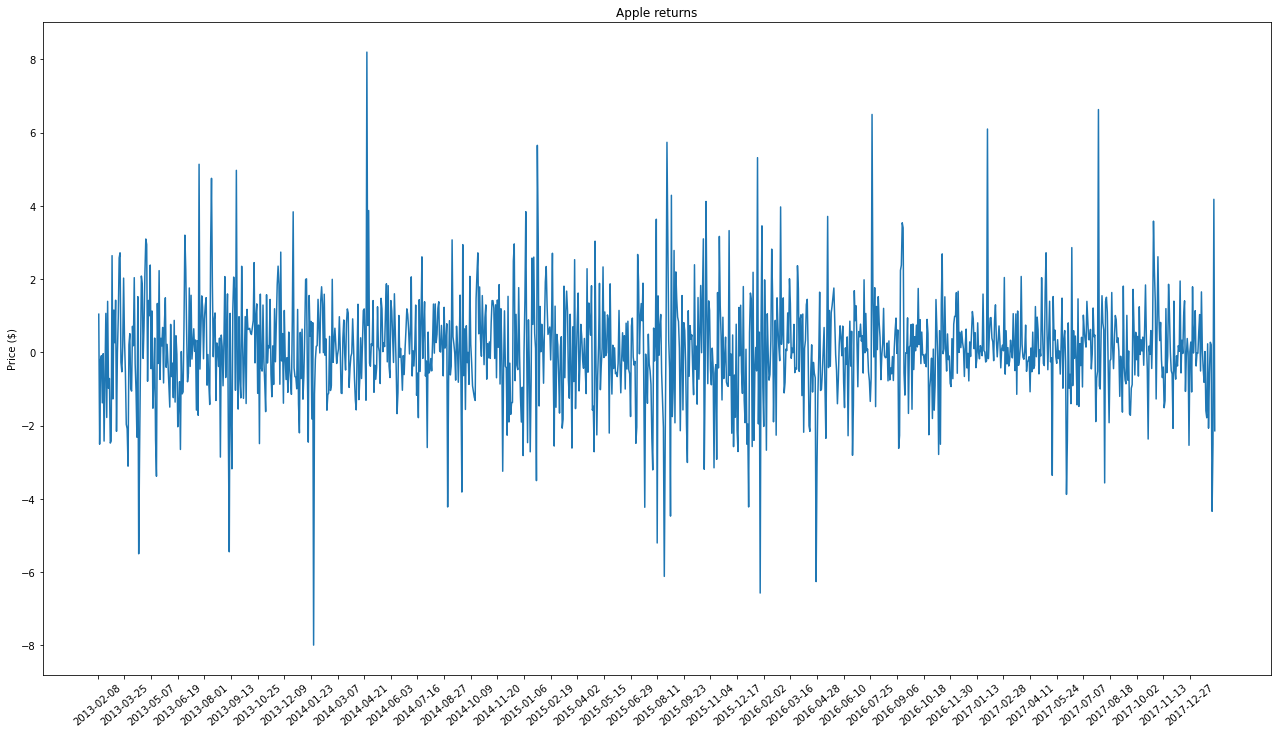

In [14]:
##plot the price
df = apple.copy()
plt.figure(figsize = (22,12))
plt.plot(apple.index, apple['ret'])
plt.title('Apple returns')
plt.xticks(range(0,apple.shape[0],30),apple['date'].loc[::30],rotation=40)
plt.ylabel('Price ($)');
plt.show()


In [0]:
split_time = 1100
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [16]:
print(x_train.shape)
print(x_valid.shape)

(1100,)
(158,)


In [17]:
type(x_train)

numpy.ndarray

In [0]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [0]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [20]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400.0)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mse"])
history = model.fit(dataset, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
34/34 [==============================] - 0s 10ms/step - loss: 10.0847 - mse: 179.7514 - lr: 1.0000e-08
Epoch 2/100
34/34 [==============================] - 0s 8ms/step - loss: 9.9632 - mse: 176.7975 - lr: 1.1220e-08
Epoch 3/100
34/34 [==============================] - 0s 8ms/step - loss: 9.8375 - mse: 173.7344 - lr: 1.2589e-08
Epoch 4/100
34/34 [==============================] - 0s 9ms/step - loss: 9.7235 - mse: 170.9232 - lr: 1.4125e-08
Epoch 5/100
34/34 [==============================] - 0s 8ms/step - loss: 9.6091 - mse: 168.1198 - lr: 1.5849e-08
Epoch 6/100
34/34 [==============================] - 0s 8ms/step - loss: 9.4947 - mse: 165.2003 - lr: 1.7783e-08
Epoch 7/100
34/34 [==============================] - 0s 9ms/step - loss: 9.3823 - mse: 162.0594 - lr: 1.9953e-08
Epoch 8/100
34/34 [==============================] - 0s 8ms/step - loss: 9.2671 - mse: 158.8478 - lr: 2.2387e-08
Epoch 9/100
34/34 [==============================] - 0s 8ms/step - loss: 9.1381 - mse: 155.128

(1e-08, 0.0001, 0.0, 30.0)

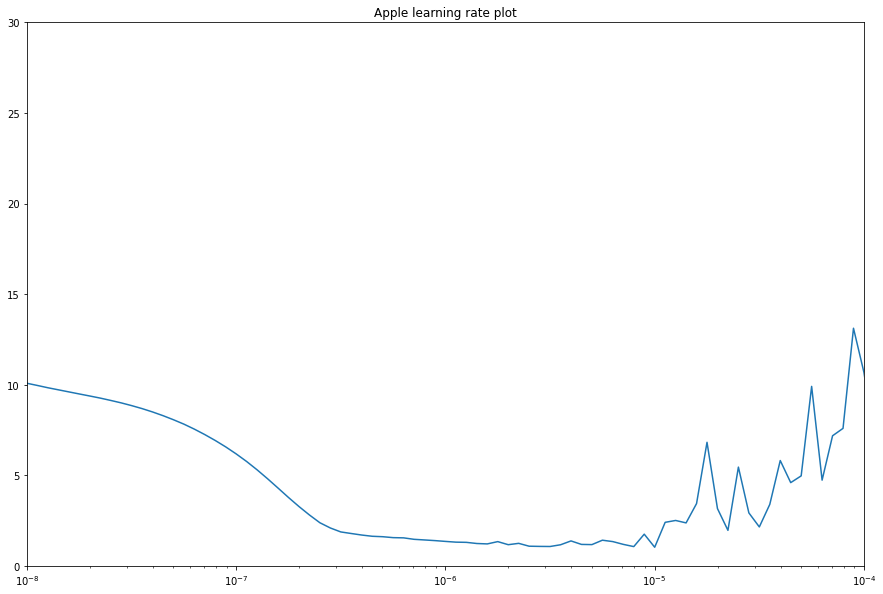

In [22]:
plt.figure(figsize=(15,10))
plt.semilogx(history.history["lr"], history.history["loss"])
plt.title("Apple learning rate plot")
plt.axis([1e-8, 1e-4, 0, 30])

In [23]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400.0)
])


model.compile(loss=tf.keras.losses.Huber(), optimizer=tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9),metrics=["mse"])
history = model.fit(dataset,epochs=300,verbose=1)

Epoch 1/300
34/34 [==============================] - 0s 9ms/step - loss: 4.7436 - mse: 52.1957
Epoch 2/300
34/34 [==============================] - 0s 8ms/step - loss: 1.6323 - mse: 7.2336
Epoch 3/300
34/34 [==============================] - 0s 8ms/step - loss: 1.7377 - mse: 7.9248
Epoch 4/300
34/34 [==============================] - 0s 8ms/step - loss: 2.0392 - mse: 9.4328
Epoch 5/300
34/34 [==============================] - 0s 8ms/step - loss: 2.5264 - mse: 13.2097
Epoch 6/300
34/34 [==============================] - 0s 8ms/step - loss: 1.6944 - mse: 7.3034
Epoch 7/300
34/34 [==============================] - 0s 8ms/step - loss: 1.3627 - mse: 5.4696
Epoch 8/300
34/34 [==============================] - 0s 8ms/step - loss: 1.8388 - mse: 7.7722
Epoch 9/300
34/34 [==============================] - 0s 9ms/step - loss: 2.0054 - mse: 9.0221
Epoch 10/300
34/34 [==============================] - 0s 8ms/step - loss: 1.5397 - mse: 6.2137
Epoch 11/300
34/34 [==============================] - 0s 

In [0]:
forecast = []
results = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]

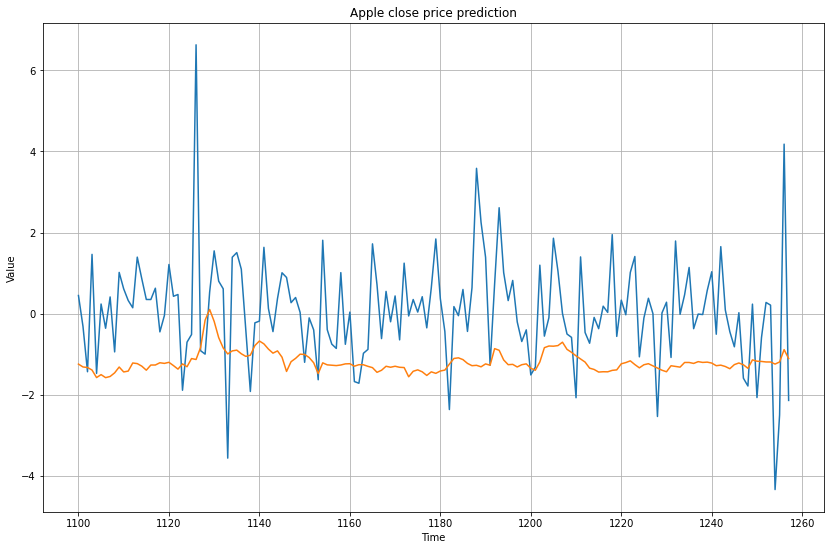

In [25]:
plt.figure(figsize=(14, 9))
plt.title("Apple Retrns prediction")
plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [26]:
tf.keras.metrics.mean_squared_error(x_valid, results).numpy()

3.2540238

In [27]:
print("RMSE= " , math.sqrt(tf.keras.metrics.mean_squared_error(x_valid, results).numpy()))

RMSE=  1.8038912911701461


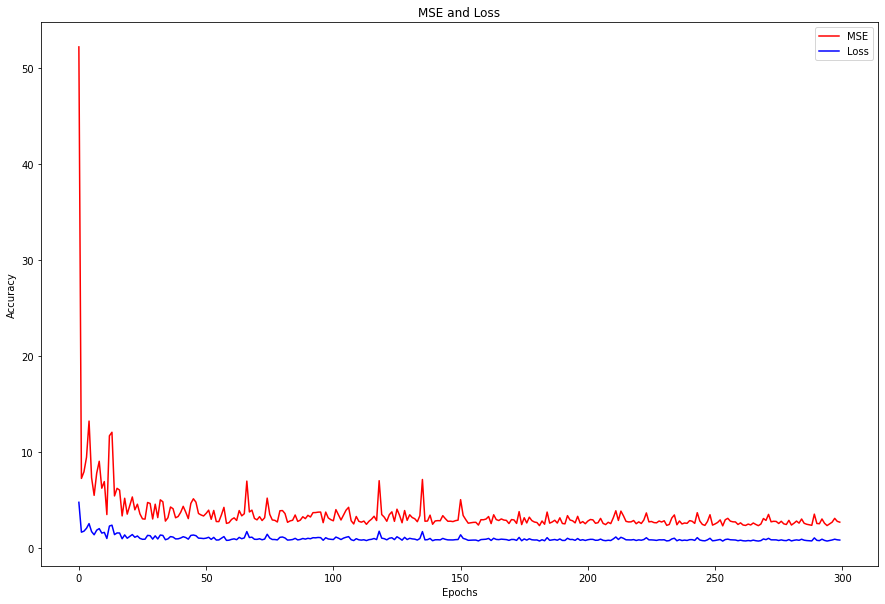

<Figure size 432x288 with 0 Axes>

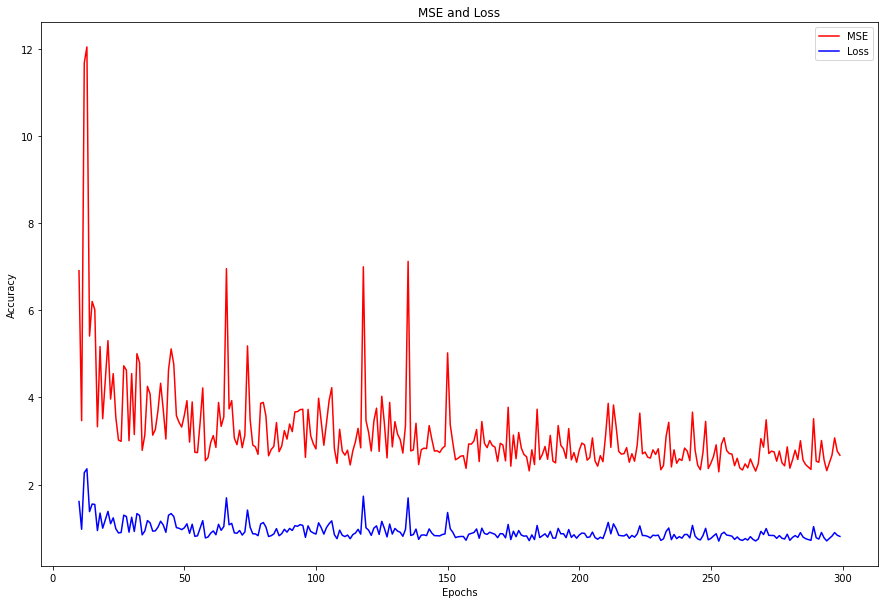

In [29]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mse=history.history['mse']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.figure(figsize=(15,10))
plt.plot(epochs, mse, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MSE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MSE", "Loss"])

plt.figure()

epochs_zoom = epochs[10:]
mse_zoom = mse[10:]
loss_zoom = loss[10:300]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.figure(figsize=(15,10))
plt.plot(epochs_zoom, mse_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MSE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MSE", "Loss"])

